Imports 

In [1]:
import argparse, yaml
from experiments.base_experiment import BaseExperiment
import numpy as np
from matplotlib import pyplot as plt

ExperimentFactory calss 

In [2]:
class ExperimentFactory:
    @staticmethod
    def create_experiment(config) -> BaseExperiment:
        # create and return the corresponding experiment instance based on config
        experiment_type = config['experiment']['type']
        if experiment_type == 'gaussian_classification':
            from experiments.gaussian_classification_experiment import GaussianClassificationExperiment
            return GaussianClassificationExperiment(config)
        elif experiment_type == 'mnist_classification':
            from experiments.mnist_classification_experiment import MnistClassificationExperiment
            return MnistClassificationExperiment(config)
        else:
            raise ValueError(f"Unknown experiment type: {experiment_type}")

Reading the config file and creating the experiment instance 

In [6]:
config_path = "configs/mnist_config.yaml"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
    
exp = ExperimentFactory.create_experiment(config)

Using CPU for evaluation.
Created the model: MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=False)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=10, out_features=2, bias=False)
    (3): LeakyReLU(negative_slope=0.1)
  )
)
Loaded test dataset with 1800 samples from Mnist dataset.
Created test DataLoader.
Initializing MnistClassificationExperiment completed.


**Synthetic Gaussian and MNIST datasets**

***DOC & True error distribution***

Estimating classifier density D(E) with 1000000 trials.


100%|██████████| 1000000/1000000 [03:54<00:00, 4256.28it/s]


Estimating classifier density completed.


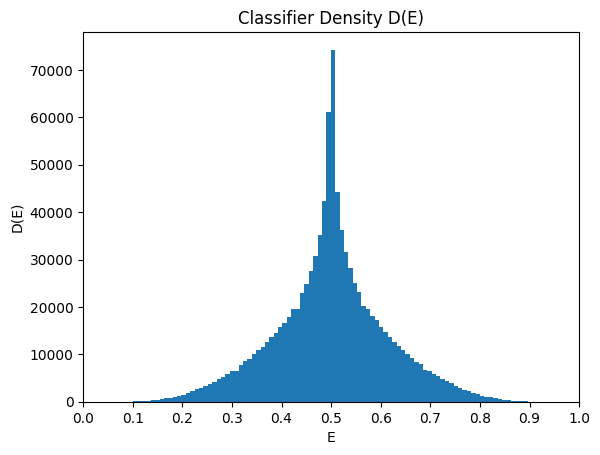

In [7]:
# ---------------------------------------------
# 1) Estimate classifier density D(E) (left plot)
# ---------------------------------------------
exp.logger.log(f"Estimating classifier density D(E) with {exp.doc_config['n_trials']} trials.")
true_errors = exp.estimate_classifier_density()
exp.logger.save_numpy_array(np.array(true_errors), "classifier_density.npy")
exp.logger.log(f"Estimating classifier density completed.")
hist_fig, _ = exp.plotter.plot_histogram(data=true_errors,
                                            bins=exp.doc_config['histogram_bins'],
                                            title = "Classifier Density D(E)",
                                            xlabel = "E",
                                            ylabel = "D(E)")
exp.logger.save_figure(hist_fig, "classifier_density_histogram.png")
plt.figure(hist_fig)   # activate the figure
plt.show()

In [ ]:
# -------------------------------------------------------------------
# 2) Estimate true-error distribution of ERM solutions (middle plot)
# -------------------------------------------------------------------
exp.logger.log("Estimating true error distribution for random weights with zero training error.")
solutions_true_errors = exp.estimate_true_error_distribution()
# Save numpy array of zero empirical true errors
exp.logger.save_numpy_array(np.array(solutions_true_errors, dtype=object), "solutions_true_errors.npy")
# plot boxplot of true errors for different training set sizes
boxplot_fig, _ = exp.plotter.plot_boxplot(true_errors=solutions_true_errors,
                                            n_values=exp.erm_config['n_values'],
                                            title="True Error Distribution for Random Weights with Zero Training Error",
                                            xlabel="Number of Training Samples",
                                            ylabel="True Error")
exp.logger.save_figure(boxplot_fig, "solutions_true_error_boxplot.png")
plt.figure(boxplot_fig)   # activate the figure
plt.show()

501357


In [ ]:
# -------------------------------------------------------------------
# 3) Right-column plot (red x vs blue x)
#     - red x: empirical mean of ERM true errors (from middle plot)
#     - blue x: DOC-based predicted mean computed from D(E) (left plot)
# -------------------------------------------------------------------
exp.logger.log("Computing DOC-based predicted mean true error and comparing with ERM empirical means.")
# Red crosses: empirical mean test error for each n
erm_means = np.array([float(np.mean(errs)) for errs in solutions_true_errors], dtype=float)
# Blue crosses: DOC prediction from D(E)
doc_means = exp.doc_predicted_mean_error(true_errors)
# Plot comparison (right-column figure)
doc_vs_erm_fig, ax = exp.plotter.plot_doc_vs_erm(exp.erm_config['n_values'], erm_means, doc_means)
exp.logger.save_figure(doc_vs_erm_fig, "doc_vs_erm_mean_true_error.png")

plt.figure(doc_vs_erm_fig)   # activate the figure
plt.show()